First r where kx > 0 at d = 400D: r = 1.01742424, kx = 0.00020605
First r where kx > 0 at d = 600D: r = 1.00959596, kx = 0.00008120
First r where kx > 0 at d = 800D: r = 1.00555556, kx = 0.00007217


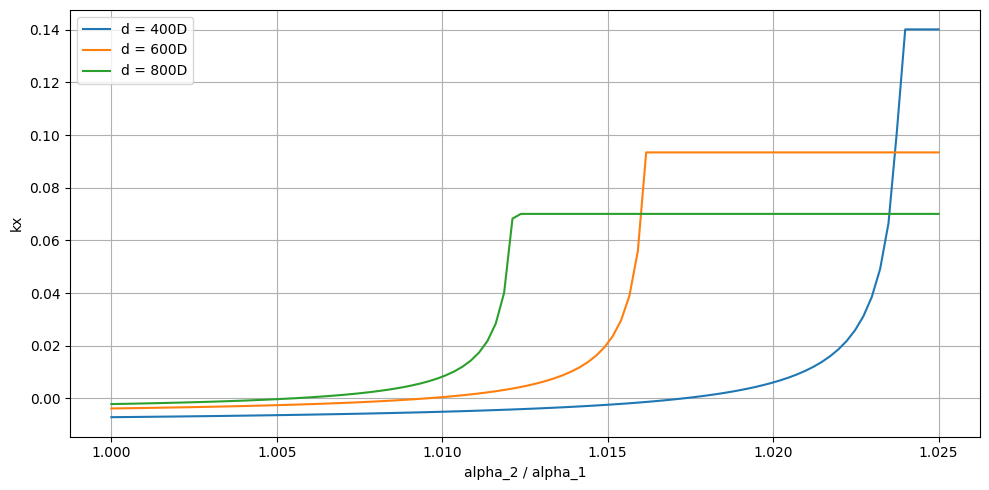

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
U_0 = 10
z_0 = 0.0001
D = 100
z_H = 100
C_T = 0.8
s_x = 10
s_y = 10
s_d = s_x * D
s_c = s_y * D
kappa = 0.4

l_farm = int(12000)
w_farm = int(12000 + (2 * D / 2))
h_farm = D
k_w = 0.05

A_0 = (w_farm * h_farm) + (2 * w_farm * k_w * l_farm) + (2 * h_farm * k_w * l_farm) + (4 * (k_w * l_farm)**2)
c_t = (np.pi * C_T * D**2) / (8 * s_d * s_c)
nu_star = 28 * np.sqrt(c_t)
beta = nu_star / (1 + nu_star)
z_0WF = z_H * (1 + D / (2 * z_H))**beta * np.exp(-kappa * (c_t + (kappa / np.log((z_H / z_0) * (1 - D / (2 * z_H))**beta))**2)**-0.5)

alpha_1 = 0.8
ratios = np.linspace(1, 1.025, 100)

# Downstream distances (multiples of D)
d_multiples = [400, 600, 800]

# Store kx values: {d_multiple: {ratio: kx_value}}
kx_all = {}

fig, ax = plt.subplots(figsize=(10, 5))

for mult in d_multiples:
    d = mult * D
    x_1 = -l_farm
    x_2 = 0
    x_3 = d
    x = np.linspace(x_1, x_3 - 1, int(x_3 - x_1))

    h_1 = np.full_like(x, np.nan, dtype=float)
    h_2 = np.full_like(x, np.nan, dtype=float)
    U = np.full_like(x, np.nan, dtype=float)
    U[0] = U_0

    alpha_2 = {}
    kx = {}

    for r in ratios:
        alpha_2[r] = r * alpha_1

        h_1[x >= x_1] = z_H + ((x[x >= x_1] - x_1) / z_0WF)**alpha_1 * z_0WF
        h_2[x >= x_2] = ((x[x >= x_2] - x_2) / z_0WF)**alpha_2[r] * z_0WF

        idx1 = h_1 >= z_H
        U[idx1] = U_0 * (np.log(h_1[idx1] / z_0) * np.log(z_H / z_0WF)) / (np.log(h_1[idx1] / z_0WF) * np.log(z_H / z_0))

        idx2 = (x >= x_2) & (h_2 >= z_H)
        U[idx2] = U_0 * (np.log(h_1[idx2] / z_0) * np.log(h_2[idx2] / z_0WF)) / (np.log(h_1[idx2] / z_0WF) * np.log(h_2[idx2] / z_0))

        for i in range(1, len(U)):
            if U[i] >= U_0 * 0.9999:
                U[i] = U_0 * 0.9999
            elif U[i] < 0:
                U[i] = 0

        u_s = (U_0 - U[-1]) / U_0

        kx[r] = (- h_farm/4 - w_farm/4 + (np.sqrt(h_farm**2 + 2*A_0 + w_farm**2 - 4*A_0 + 4*(A_0 * (c_t / (2*(u_s - u_s**2))))))/4)/d

    # Find and print the first value of r where kx is above 0
    for r in ratios:
        if kx[r] > 0:
            print(f'First r where kx > 0 at d = {mult}D: r = {r:.8f}, kx = {kx[r]:.8f}')
            break

    kx_all[mult] = kx  # Save for this downstream distance
    ax.plot(ratios, [kx[r] for r in ratios], label=f'd = {mult}D')

ax.set_xlabel('alpha_2 / alpha_1')
ax.set_ylabel('kx')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

# Construct DataFrame
kx_df = pd.DataFrame({'ratio': ratios})
for mult in d_multiples:
    kx_df[f'kx_d={mult}D'] = [kx_all[mult][r] for r in ratios]
